In [1]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/modules/')
import simulation
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner
import pickle
import scipy.stats as stats
from matplotlib.cm import get_cmap
from torch.distributions import Distribution, Uniform, Normal
import pyccl as ccl
from matplotlib.cm import get_cmap

/pbs/home/c/cmurray/.conda/envs/sbi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/pinocchio_data_vector/data_vector_pinocchio_mock_0.pkl' , allow_pickle= True )

In [14]:
np.array( pinocchio_mock['richness_bins'] ).T[0]

array([  5.        ,   6.3940202 ,   8.17669886,  10.45639553,
        13.37168084,  17.09975947,  21.86724148,  27.96391673,
        35.76036968,  45.73050519,  58.48035476,  74.7849139 ,
        95.63524998, 122.29874398, 156.39612782])

In [4]:
pinocchio_mock['count_richness_redshift'].T

array([[  61.,  178.,  340.,  668., 1042., 1333., 1692., 1720., 1570.,
        1187.,  848.,  574.,  369.,  237.,  134.],
       [  86.,  225.,  548.,  997., 1668., 2232., 2702., 2814., 2407.,
        1844., 1281.,  790.,  499.,  279.,  149.],
       [  99.,  235.,  613., 1214., 1832., 2658., 2971., 2899., 2549.,
        1938., 1411.,  857.,  482.,  265.,  127.],
       [  86.,  257.,  544., 1094., 1712., 2296., 2642., 2706., 2310.,
        1663., 1112.,  672.,  385.,  209.,  107.],
       [  90.,  181.,  470.,  903., 1356., 1845., 2037., 2151., 1700.,
        1262.,  834.,  561.,  262.,  114.,   51.]])

In [5]:
10**np.linspace( np.log10( 20 ) , np.log10( 200 ) , 6 )

array([ 20.        ,  31.69786385,  50.23772863,  79.62143411,
       126.1914689 , 200.        ])

In [22]:
richness_cents = np.array( [ ( np.array( pinocchio_mock['richness_bins'] ).T[0] + np.array( pinocchio_mock['richness_bins'] ).T[1] )/2. ])[0]

In [23]:
redshift_cents = np.array( [ ( np.array( pinocchio_mock['redshift_bins'] ).T[0] + np.array( pinocchio_mock['redshift_bins'] ).T[1] )/2. ])[0]

In [24]:
richness_cents

array([  5.6970101 ,   7.28535953,   9.31654719,  11.91403818,
        15.23572015,  19.48350047,  24.91557911,  31.86214321,
        40.74543743,  52.10542998,  66.63263433,  85.21008194,
       108.96699698, 139.3474359 , 178.19806391])

In [25]:
pinocchio_mock

{'count_richness_redshift': array([[  61.,   86.,   99.,   86.,   90.],
        [ 178.,  225.,  235.,  257.,  181.],
        [ 340.,  548.,  613.,  544.,  470.],
        [ 668.,  997., 1214., 1094.,  903.],
        [1042., 1668., 1832., 1712., 1356.],
        [1333., 2232., 2658., 2296., 1845.],
        [1692., 2702., 2971., 2642., 2037.],
        [1720., 2814., 2899., 2706., 2151.],
        [1570., 2407., 2549., 2310., 1700.],
        [1187., 1844., 1938., 1663., 1262.],
        [ 848., 1281., 1411., 1112.,  834.],
        [ 574.,  790.,  857.,  672.,  561.],
        [ 369.,  499.,  482.,  385.,  262.],
        [ 237.,  279.,  265.,  209.,  114.],
        [ 134.,  149.,  127.,  107.,   51.]]),
 'richness_bins': [[4.999999999999999, 6.394020196998705],
  [6.394020196998705, 8.17669885592547],
  [8.17669885592547, 10.456395525912733],
  [10.456395525912733, 13.371680836098578],
  [13.371680836098578, 17.099759466766965],
  [17.099759466766965, 21.86724147886556],
  [21.86724147886556, 2

In [26]:
pinocchio_mock['count_richness_redshift'][0]

array([61., 86., 99., 86., 90.])

(13.7, 15.0)

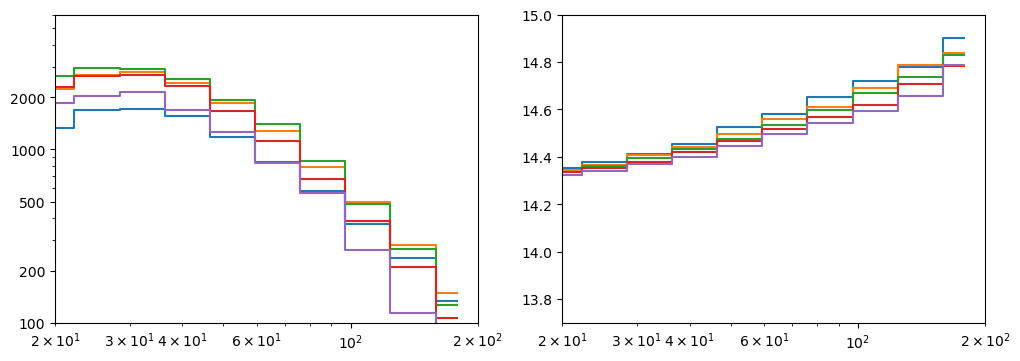

In [27]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)

for i in range( 0 , len( pinocchio_mock['count_richness_redshift'].T ) ):
    plt.plot( richness_cents , 
              pinocchio_mock['count_richness_redshift'].T[i] , drawstyle = 'steps-mid')

plt.xscale('log')
plt.yscale('log')
plt.yticks( [ 100 , 200 , 500 , 1000 , 2000 ], labels = [ 100 , 200 , 500 , 1000 , 2000 ])
plt.xlim( 20 , 200 )
plt.ylim( 100 , 6000 )

plt.subplot(122)

for i in range( 0 , len( pinocchio_mock['count_richness_redshift'].T ) ):
    plt.plot( richness_cents , 
              np.log10( pinocchio_mock['mean_mass_richness_redshift'].T[i] ) , drawstyle = 'steps-mid')

plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 13.7 , 15 )

In [47]:
richness_bins = list(np.array(pinocchio_mock['richness_bins']).T[0])
richness_bins.append( np.array( pinocchio_mock['richness_bins'] ).T[1][-1]  )

redshift_bins = list(np.array(pinocchio_mock['redshift_bins']).T[0])
redshift_bins.append( np.array( pinocchio_mock['redshift_bins'] ).T[1][-1]  )

In [73]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )
stacked_simulator_pl.selection_richness = 0
stacked_simulator_pl.dOmega = 0.25 * 4*np.pi
stacked_simulator_pl.richness_bins = richness_bins
stacked_simulator_pl.redshift_bins = redshift_bins
stacked_simulator_pl.sigma_mwl = 0.25
stacked_simulator_pl.include_mwl_measurement_errors = False
#stacked_simulator_pl.mwl_std = mwl_std
stacked_simulator_pl.correlation_mass_evolution = False
stacked_simulator_pl.set_richness_mass_relation( 'power law' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.05 ) , 
                               log10m_bins=  np.arange( 14.2 , 16, 0.01))
stacked_simulator_pl.hmf = ccl.halos.MassFuncDespali16(mass_def='vir')

In [74]:
# stacked_simulator_hm = simulation.Universe_simulation( 'stacked_counts' ,
#                                                     variable_params=['omega_m', 
#                                                                      'sigma_8', 
#                                                                      'h',
#                                                                      'alpha' , 
#                                                                      'B' ,
#                                                                      'log10Mmin',
#                                                                      'sigma' ],
#                                                     fixed_params={'w_0': -1, 'w_a': 0 } )
# stacked_simulator_hm.selection_richness = 0
# stacked_simulator_hm.dOmega = 0.25 * 4*np.pi
# stacked_simulator_hm.richness_bins = richness_bins
# stacked_simulator_hm.redshift_bins = redshift_bins
# stacked_simulator_hm.sigma_mwl = 0.3
# stacked_simulator_hm.include_mwl_measurement_errors = False
# #stacked_simulator_hm.mwl_std = mwl_std
# stacked_simulator_hm.correlation_mass_evolution = False
# stacked_simulator_hm.set_richness_mass_relation( 'halo model' )
# stacked_simulator_hm.set_bins( z_bins = np.arange( 0.2 , 1 , 0.05 ) , 
#                                log10m_bins=  np.arange( 14.2 , 16, 0.01))
# stacked_simulator_hm.hmf = ccl.halos.MassFuncDespali16(mass_def='vir')

In [75]:
# Define individual priors with correct tensor shape
prior_om = Uniform(torch.tensor([0.05]), torch.tensor([1.0]))
prior_s8 = Uniform(torch.tensor([0.5]), torch.tensor([1.5]))
prior_h = Normal(torch.tensor([0.7]), torch.tensor([0.1]))  # Normal prior on h
prior_alpha = Uniform(torch.tensor([0.4]), torch.tensor([1.2]))
prior_c = Uniform(torch.tensor([1.0]), torch.tensor([5.0]))
prior_beta = Uniform(torch.tensor([-5.0]), torch.tensor([5.0]))
prior_sigma = Uniform(torch.tensor([0.05]), torch.tensor([0.5]))

# Combine the priors into a list for processing
priors = [ prior_om, prior_s8, prior_h, prior_alpha, prior_c , prior_beta , prior_sigma ]

In [76]:
# stacked_simulator_pl._get_parameter_set( torch.Tensor([ 0.3 , 0.8 , 0.7 , 1 , 3. , 0.1 ]) )

In [77]:
# # infer posteriors
# pinocchio_posterior = infer( stacked_simulator_pl.run_simulation , 
#                              priors, 
#                              method = 'SNPE', 
#                              num_simulations = 1000 , 
#                              num_workers = 1 )

In [78]:
len( richness_cents ) , len( redshift_cents ) 

(15, 5)

In [79]:
15*5

75

In [80]:
# Use a colormap that goes from blue to red
cmap = get_cmap('coolwarm')

/tmp/ipykernel_33209/4130027877.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('coolwarm')


In [81]:
sim_obs = stacked_simulator_pl.run_simulation( torch.Tensor([ 0.3 , 0.83 , 0.67 , 2.3 , 3.2 , 0 , 0.5 ]))

In [88]:
sim_n_clusters = sim_obs[:75].reshape( len( richness_cents ) , len( redshift_cents )  )
sim_mwl_mean = sim_obs[75:].reshape( len( richness_cents ), len( redshift_cents ) )

In [92]:
sim_n_clusters

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00],
       [4.000e+00, 6.000e+00, 4.000e+00, 5.000e+00, 2.000e+00],
       [2.100e+01, 2.100e+01, 3.800e+01, 3.000e+01, 1.900e+01],
       [5.300e+01, 8.700e+01, 1.290e+02, 7.600e+01, 5.700e+01],
       [1.160e+02, 2.100e+02, 3.070e+02, 2.310e+02, 1.370e+02],
       [2.730e+02, 4.640e+02, 6.960e+02, 5.180e+02, 2.640e+02],
       [5.130e+02, 7.820e+02, 1.201e+03, 8.710e+02, 5.130e+02],
       [8.040e+02, 1.242e+03, 1.980e+03, 1.375e+03, 8.350e+02],
       [1.033e+03, 1.600e+03, 2.642e+03, 1.788e+03, 1.072e+03],
       [1.195e+03, 1.906e+03, 2.871e+03, 1.965e+03, 1.155e+03],
       [1.159e+03, 1.909e+03, 2.892e+03, 2.014e+03, 1.111e+03],
       [1.083e+03, 1.705e+03, 2.625e+03, 1.779e+03, 1.012e+03]])

In [91]:
sim_n_clusters[3]

array([1., 2., 2., 1., 1.])

In [94]:
sim_mwl_mean

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [14.15313875, 14.32871193, 14.31592994, 14.26161212, 14.07438657],
       [14.30155499, 14.15845887, 14.22199579, 14.19843745, 14.32316639],
       [14.12537424, 14.23077594, 14.22382159, 14.21315606, 14.21516553],
       [14.24181825, 14.22861875, 14.22188121, 14.2456147 , 14.24286552],
       [14.23227806, 14.24950994, 14.23525943, 14.2260233 , 14.2437465 ],
       [14.24272279, 14.24611843, 14.23518263, 14.24675575, 14.23909206],
       [14.25921413, 14.25243978, 14.25357888, 14.25205419, 14.25209037],
       [14.26683637, 14.26775027, 14.26765063, 14.26237342, 14.25745065],
       [14.28110041, 14.28546203, 14.27356257, 14.2734273 , 14.27172317],
       [14.29611586, 14.29850662, 14.2998937 , 14.29193735, 14.29383957],
       [14.32501898, 14.33020083, 14.3

/tmp/ipykernel_33209/3341567992.py:20: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim( 0 , 7000 )


Text(0, 0.5, '$log_{10}\\left< M | \\lambda \\right>$')

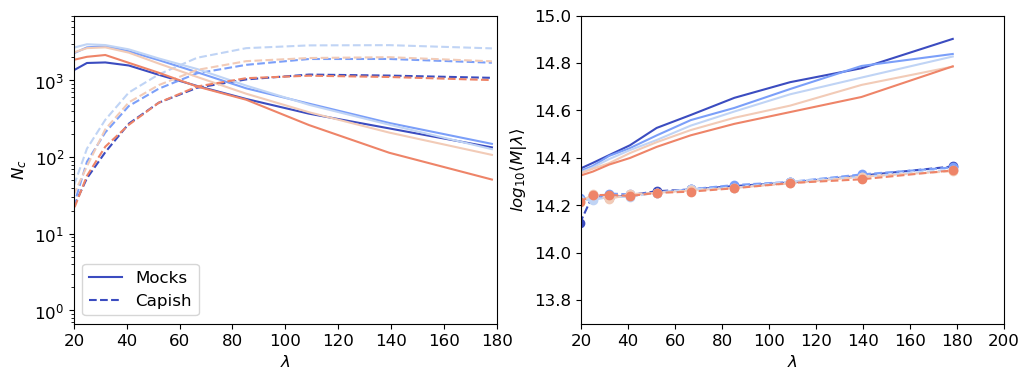

In [93]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)



for i in range( 0 , len( pinocchio_mock['count_richness_redshift'].T ) ):
    color = cmap(i /  len( pinocchio_mock['count_richness_redshift'].T ) ) 
    if i == 0:
        plt.plot( richness_cents , 
                  pinocchio_mock['count_richness_redshift'].T[i] , '-'  , color = color , label = 'Mocks' )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters.T[i] , '--' , color = color , label = 'Capish' )
    else:
        plt.plot( richness_cents , 
                  pinocchio_mock['count_richness_redshift'].T[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters.T[i] , '--' , color = color )

#plt.xscale('log')
plt.yscale('log')
plt.xlim( 20 , 180 )
plt.ylim( 0 , 7000 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$N_c$' , fontsize = 12 )
plt.legend( fontsize = 12 )

plt.subplot(122)

for i in range( 0 , len( pinocchio_mock['count_richness_redshift'].T ) ):
    color = cmap(i /  len( pinocchio_mock['count_richness_redshift'].T ) ) 
    plt.plot( richness_cents , 
              np.log10( pinocchio_mock['mean_mass_richness_redshift'].T[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')
    plt.plot( richness_cents , sim_mwl_mean.T[i] , 'o--' , color = color )

#plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 13.7 , 15 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$log_{10}\left< M | \lambda \right>$' , fontsize = 12 )

In [235]:
sim_mwl_mean

array([[14.29690837, 14.29540805, 14.29473797, 14.28945975, 14.28236805],
       [14.34833689, 14.34467585, 14.33655036, 14.33371139, 14.32849114],
       [14.44854769, 14.43891456, 14.42534381, 14.41687466, 14.40739413],
       [14.57910743, 14.57283173, 14.56108406, 14.53964145, 14.5454515 ],
       [14.71826496, 14.71492679, 14.69905135, 14.68998822, 14.68218381],
       [14.89549014, 14.87139588, 14.84965265, 14.85448622, 14.81406249]])

In [236]:
sim_n_clusters

array([[1937., 2871., 4444., 2955., 1652.],
       [2828., 4274., 6169., 3999., 2222.],
       [2079., 3194., 4431., 2702., 1448.],
       [1151., 1548., 2019., 1153.,  559.],
       [ 522.,  633.,  732.,  377.,  168.],
       [ 198.,  213.,  217.,  108.,   38.]])